In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
import scipy

The Unprocessed Input feature distribution


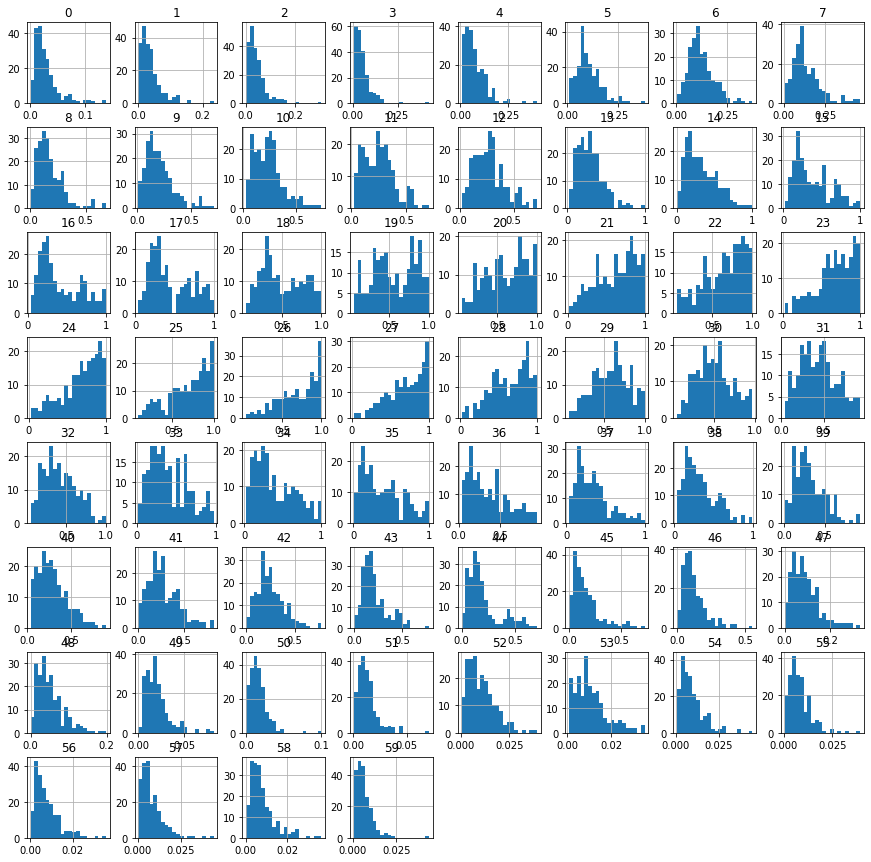

In [ ]:
def read_data():
  df = pd.read_csv('sonar.all-data.csv',header=None)
  # print(df.head())
  # print(df.info())
  # print(len([i for i in df.isnull().sum() if i!= 0 ]))
  return df

df = read_data()

df.hist(bins = 20, figsize = (15,15))
print("The Unprocessed Input feature distribution")
plt.show()

In [ ]:
def data_encoder(df):
  X = df.iloc[:,:-1].values
  y = df.iloc[:,-1].values[:,np.newaxis]
  encoder = sk.preprocessing.OneHotEncoder()
  y_encoded = encoder.fit_transform(y).toarray()[:,0]
  y_encoded = y_encoded [:,np.newaxis]
  # print("X Shape  ->", X.shape)  
  # print("y Shape  ->", y_encoded.shape)
  return X, y_encoded

def feature_scaling(X):
  #Normalisation of Input
  return (X - X.min(axis = 0))/(X.max(axis = 0) - X.min(axis = 0))

def box_cox_transform(X, epi = 0.000006):
  X = X - X.min(axis = 0) + epi
  for i in range(X.shape[1]):
    # plt.hist(X[:,i], bins = 30, color='b')
    # plt.show()
    X[:,i], bc_param = stats.boxcox(X[:,i])
    # plt.hist(X[:,i], bins = 30, color = 'r')
    # plt.show()
  return X

X Shape  -> (208, 60)
y Shape  -> (208,)
The Processed Input feature distribution


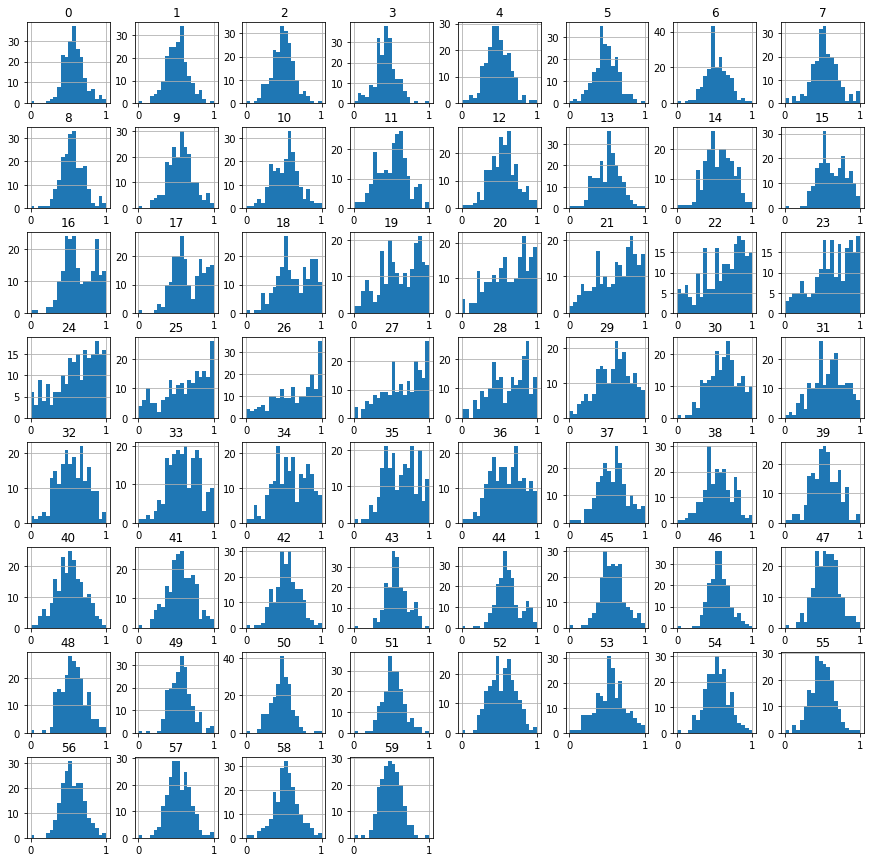

In [ ]:
def plot_range(X):
  fig, axes = plt.subplots(1,1,figsize = (15,10))
  axes.plot(np.min(X, axis = 0), label ='min')
  axes.plot(np.max(X, axis = 0), label ='max')
  axes.tick_params(labelsize=20)
  axes.legend(fontsize = 20)
  axes.set_title("Plot", fontsize = 20)
  axes.set_ylabel("Value", fontsize = 20)
  axes.set_xlabel("Feature_i", fontsize = 20)
  plt.show()

def preprocess_data(df):
  X, y = data_encoder(df)
  y = y.ravel()
  # plot_range(X)
  X = box_cox_transform(X)
  # plot_range(X)
  X = feature_scaling(X)
  # plot_range(X)
  print("X Shape  ->", X.shape)  
  print("y Shape  ->", y.shape)
  return X, y

X, y = preprocess_data(df)

df_ = pd.DataFrame(X)
df_.hist(bins = 20, figsize = (15,15))
print("The Processed Input feature distribution")
plt.show()

In [ ]:
# corr = df.corr().values
# plt.show()
# f = plt.figure(figsize=(15, 15), dpi=80)
# plt.matshow(corr, fignum = f.number)
# plt.colorbar()
# plt.show()

In [ ]:
X_train,X_test,y_train, y_test = train_test_split(
    X, y,
    test_size = 0.3,
    random_state = 20,
    shuffle = True
    )
print("X_train.shape " ,X_train.shape)
print("y_train.shape " ,y_train.shape)
print("X_test.shape " ,X_test.shape)
print("y_test.shape " , y_test.shape)

X_train.shape  (145, 60)
y_train.shape  (145,)
X_test.shape  (63, 60)
y_test.shape  (63,)


In [ ]:
def get_classifiers():
  return [
        ("Decision Tree", DecisionTreeClassifier(random_state=42, max_depth = 5, max_leaf_nodes = 20)),
        ("Random Forest",RandomForestClassifier(n_jobs=-1 ,random_state = 42)),  
        ("SVC",SVC(probability=True))             
    ]

param_grid ={
    "Decision Tree" :{ 
          "criterion": ['gini', 'entropy'],
          "max_depth" : list(range(1,500,20)),
         'max_leaf_nodes': list(range(2,500,20)),
         'min_samples_split':  list(range(2,500,20))
         },

         "Random Forest" :{
            'n_estimators': [3, 10, 30, 100, 300, 500],
            "max_depth": [2,4,8, 12, 16, 20, 24, 28, 32, 36, 40],
            "max_features": ['auto', 'sqrt', 'log2'],
            "min_samples_split": [ 3, 10, 30],
            "min_samples_leaf": [ 3, 10, 30],
            "bootstrap":[True, False],
            "criterion": ["gini", "entropy"]
          },  

          "SVC" : 
              {
            'C': [ 1, 10, 100, 1000, 10000, 100000 ],
            'gamma': [ 0.0001,0.0005,0.001,0.005, 0.01,0.05, 0.1,1],
            'kernel':['rbf', 'linear'], 
            'class_weight':['balanced'],
            },       
} 


In [ ]:
clf_names = []
best_params = {}
cv_results = {}

clf_list = get_classifiers()
scoring_ = 'accuracy'

for name,clf in clf_list:

    params = param_grid[name]

    cv = KFold(n_splits=10,shuffle=True, random_state=1)
    clf_search = RandomizedSearchCV( 
        clf, params, cv = cv,
        scoring=scoring_,
        return_train_score = True,
        refit = False,
        n_iter=20)
    clf_search.fit(X_train, y_train)


    cv_res = clf_search.cv_results_
    optimum_params_ = clf_search.best_params_
  
    print("Model -> " ,name)
    for mean_score, params in zip(cv_res["mean_test_score"], cv_res["params"]):
      print(mean_score, params)
    print("Optimum params ", optimum_params_)
    print('Best_cross_validation_accuracy_score = %.3f' % (clf_search.best_score_))
    print("------------------------------------")

    clf_names.append(name)
    best_params[name] = optimum_params_
    cv_results[name] =cv_res

Model ->  Decision Tree
0.41428571428571426 {'min_samples_split': 282, 'max_leaf_nodes': 202, 'max_depth': 241, 'criterion': 'gini'}
0.7938095238095237 {'min_samples_split': 82, 'max_leaf_nodes': 102, 'max_depth': 361, 'criterion': 'gini'}
0.7938095238095237 {'min_samples_split': 82, 'max_leaf_nodes': 42, 'max_depth': 421, 'criterion': 'gini'}
0.41428571428571426 {'min_samples_split': 282, 'max_leaf_nodes': 242, 'max_depth': 61, 'criterion': 'entropy'}
0.41428571428571426 {'min_samples_split': 242, 'max_leaf_nodes': 482, 'max_depth': 441, 'criterion': 'entropy'}
0.7871428571428571 {'min_samples_split': 102, 'max_leaf_nodes': 342, 'max_depth': 281, 'criterion': 'entropy'}
0.7938095238095237 {'min_samples_split': 82, 'max_leaf_nodes': 242, 'max_depth': 421, 'criterion': 'gini'}
0.41428571428571426 {'min_samples_split': 282, 'max_leaf_nodes': 22, 'max_depth': 101, 'criterion': 'entropy'}
0.41428571428571426 {'min_samples_split': 202, 'max_leaf_nodes': 402, 'max_depth': 61, 'criterion': 'g

In [ ]:
# boxplot algorithm comparison
def flot_model_performance(names, results):
  f, axes = plt.subplots(1, figsize =(10,10))
  axes.boxplot(results)
  axes.set_xticklabels(names)
  axes.tick_params(labelsize=20)
  axes.legend(fontsize = 20)
  axes.set_title('Algorithm Comparison', fontsize = 20)
  axes.set_ylabel("Accuracy_score", fontsize = 20)
  axes.set_xlabel("Model", fontsize = 20)
  plt.show()

In [ ]:
best_params

{'Decision Tree': {'criterion': 'gini',
  'max_depth': 361,
  'max_leaf_nodes': 102,
  'min_samples_split': 82},
 'Random Forest': {'bootstrap': False,
  'criterion': 'gini',
  'max_depth': 32,
  'max_features': 'log2',
  'min_samples_leaf': 10,
  'min_samples_split': 3,
  'n_estimators': 100},
 'SVC': {'C': 1, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}}

Decision Tree: 0.800893 (0.155498)
Random Forest: 0.803571 (0.147145)


No handles with labels found to put in legend.


SVC: 0.866071 (0.153041)


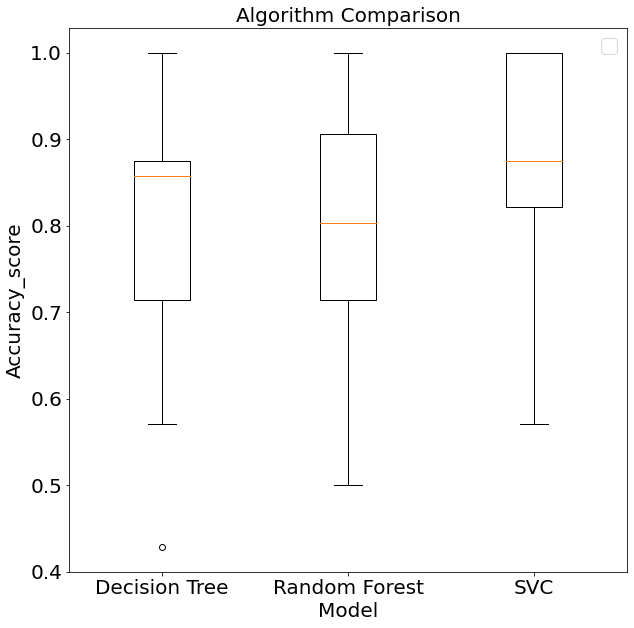

In [ ]:
names = []
results = []

seed = 2
scoring = 'accuracy'
clf_list_2 = get_classifiers()
best_fitted_clfs = []

for name, clf in clf_list_2:

  optimum_params_ = best_params[name]
  clf.set_params(**optimum_params_)
  kfold = KFold(n_splits=20, random_state=seed, shuffle = True)
  cv_results = cross_val_score(clf, X_train, y_train, cv=kfold, scoring=scoring)
  predictions.append(prediction)
  results.append(cv_results)
  names.append(name)
  clf.fit(X_train, y_train)
  best_fitted_clfs.append((name, clf))
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

flot_model_performance(names, results)

No handles with labels found to put in legend.


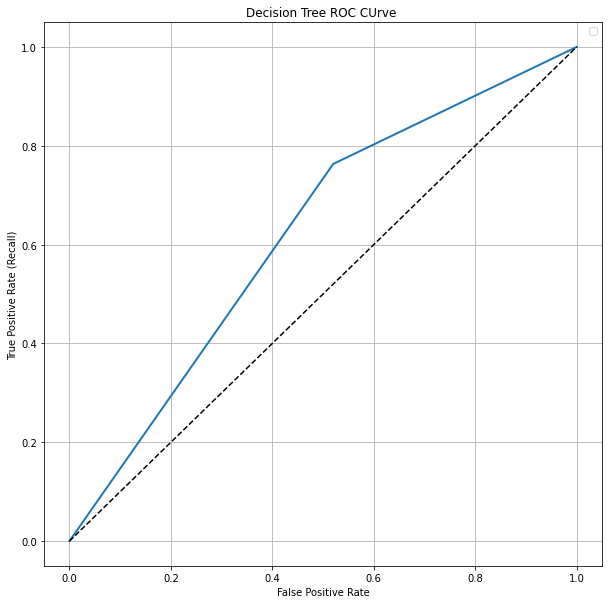

No handles with labels found to put in legend.


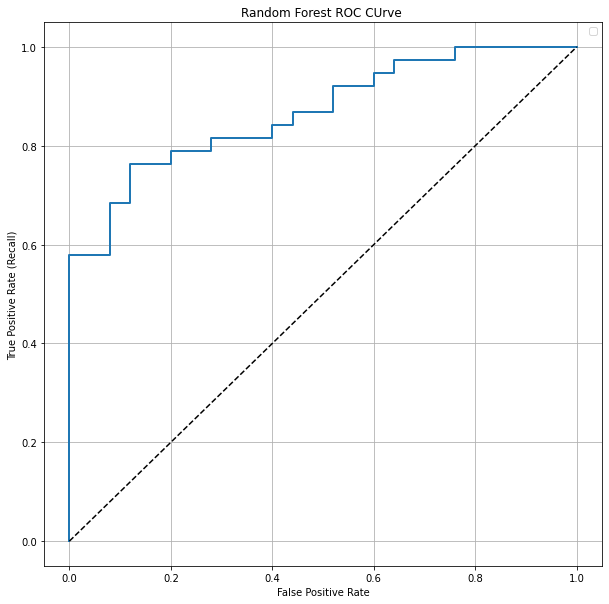

No handles with labels found to put in legend.


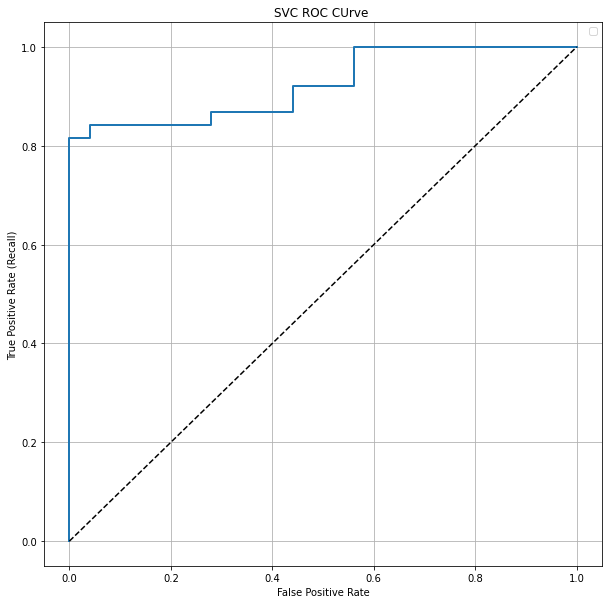

In [ ]:
 from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
  plt.subplots(1, figsize = (10,10))
  plt.plot(fpr, tpr, linewidth=2, label=label) 
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate (Recall)")
  plt.title(clf_name + " ROC CUrve ")
  plt.legend()
  plt.grid()
  plt.show()

for clf_name,clf in best_fitted_clfs :
  fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
  plot_roc_curve(fpr, tpr)
